2024-08-27 15:44:53.635471: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-27 15:44:53.670674: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-27 15:44:53.935421: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-27 15:44:54.482343: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/tmp/ipykernel_17251/1810039634.py:186: FutureWarning: You are using `torch.load` with `weights_only=False` (the current defa

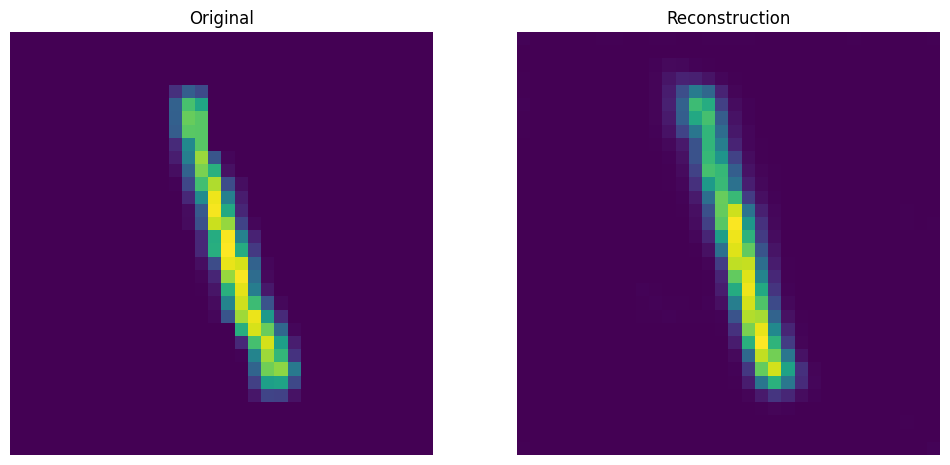

In [1]:
from torch import nn
from abc import abstractmethod
from typing import List, Any, TypeVar
import torch
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms, utils
from torch.optim import Adam, lr_scheduler
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import os
import torch.nn.functional as F
import matplotlib.pyplot as plt

Tensor = TypeVar("torch.tensor")


class BaseVAE(nn.Module):

    def __init__(self) -> None:
        super(BaseVAE, self).__init__()

    def encode(self, input: Tensor) -> List[Tensor]:
        raise NotImplementedError

    def decode(self, input: Tensor) -> Any:
        raise NotImplementedError

    def sample(self, batch_size: int, current_device: int, **kwargs) -> Tensor:
        raise NotImplementedError

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        raise NotImplementedError

    @abstractmethod
    def forward(self, *inputs: Tensor) -> Tensor:
        pass

    @abstractmethod
    def loss_function(self, *inputs: Any, **kwargs) -> Tensor:
        pass


class VanillaVAE(BaseVAE):

    def __init__(
        self, in_channels: int, latent_dim: int, hidden_dims: List = None, **kwargs
    ) -> None:
        super(VanillaVAE, self).__init__()

        self.latent_dim = latent_dim

        modules = []
        if hidden_dims is None:
            hidden_dims = [32, 64, 128]

        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(
                        in_channels,
                        out_channels=h_dim,
                        kernel_size=3,
                        stride=2,
                        padding=1,
                    ),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU(),
                )
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1] * 4 * 4, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1] * 4 * 4, latent_dim)

        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * 4 * 4)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(
                        hidden_dims[i],
                        hidden_dims[i + 1],
                        kernel_size=3,
                        stride=2,
                        padding=1,
                        output_padding=1,
                    ),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU(),
                )
            )

        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
            nn.ConvTranspose2d(
                hidden_dims[-1],
                hidden_dims[-1],
                kernel_size=3,
                stride=2,
                padding=1,
                output_padding=1,
            ),
            nn.BatchNorm2d(hidden_dims[-1]),
            nn.LeakyReLU(),
            nn.Conv2d(hidden_dims[-1], out_channels=1, kernel_size=3, padding=1),
            nn.Sigmoid(),
        )

    def encode(self, input: Tensor) -> List[Tensor]:
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)

        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    def decode(self, z: Tensor) -> Tensor:
        result = self.decoder_input(z)
        result = result.view(-1, 128, 4, 4)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input: Tensor, **kwargs) -> List[Tensor]:
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return [self.decode(z), input, mu, log_var]

    def loss_function(self, *args, **kwargs) -> dict:
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]

        kld_weight = kwargs["M_N"]  # Account for the minibatch samples from the dataset
        recons_loss = F.mse_loss(recons, input)

        kld_loss = torch.mean(
            -0.5 * torch.sum(1 + log_var - mu**2 - log_var.exp(), dim=1), dim=0
        )

        loss = recons_loss + kld_weight * kld_loss
        return {
            "loss": loss,
            "Reconstruction_Loss": recons_loss.detach(),
            "KLD": -kld_loss.detach(),
        }

    def sample(self, num_samples: int, current_device: int, **kwargs) -> Tensor:
        z = torch.randn(num_samples, self.latent_dim)
        z = z.to(current_device)
        samples = self.decode(z)
        return samples

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        return self.forward(x)[0]

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
batch_size = 128
learning_rate = 0.001
weight_decay = 0.0
scheduler_gamma = 0.95
num_epochs = 50
latent_dim = 20
img_size = 28
kld_weight = 0.00025  # weight of KL divergence in the loss

model = VanillaVAE(in_channels=1, latent_dim=latent_dim)
model.load_state_dict(torch.load('weights/vae_mnist.pth'))
model.eval().to(device)

torch.manual_seed(42)

# Transformations
transform = transforms.Compose(
    [
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
    ]
)

# Load dataset
dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)

# Split dataset into train and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Data loaders
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=4
)
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=2
)

batch = next(iter(train_loader))
images, _ = batch

images = images.to(device)
reconstructions = model(images)
reconstructions = reconstructions[0]

idx = 1

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.imshow(images[idx].permute(1, 2, 0).cpu().detach().numpy())
plt.title("Original")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(reconstructions[idx].permute(1, 2, 0).cpu().detach().numpy())
plt.title("Reconstruction")
plt.axis('off')
plt.show()

Labels shape: (60000,)
Images shape: (10000, 28, 28)


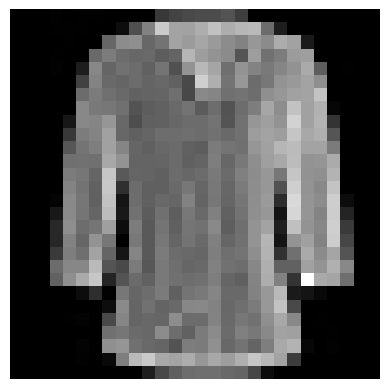

In [19]:
import numpy as np
import struct

def load_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for _ in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

# Load the label file (train-labels-idx1-ubyte)
labels = load_idx('./data/fMNIST/train-labels-idx1-ubyte')

# Load the image file (t10k-images-idx3-ubyte)
images = load_idx('./data/fMNIST/t10k-images-idx3-ubyte')

# Check the shapes of the loaded data
print(f'Labels shape: {labels.shape}')
print(f'Images shape: {images.shape}')
img = images[4]

plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

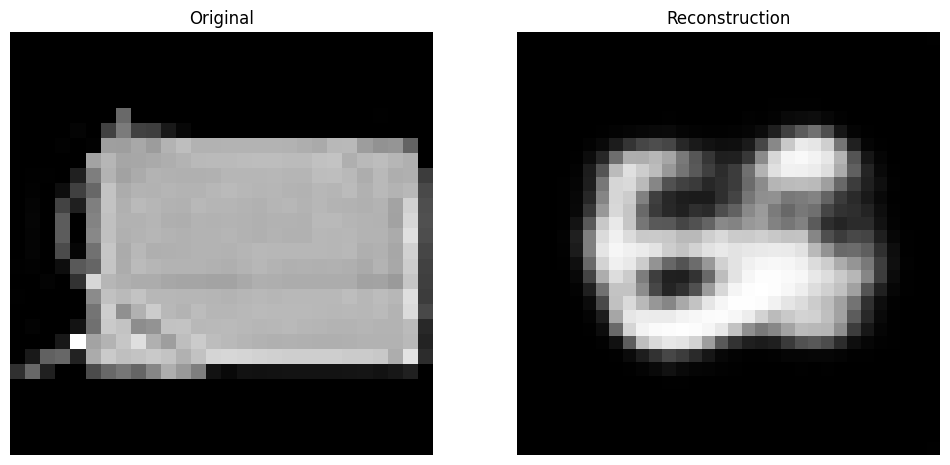

In [37]:
tensor = torch.tensor(images[18]).unsqueeze(0).unsqueeze(0).float() / 255.0

reconstruction = model(tensor.to(device))
reconstruction = reconstruction[0]

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.imshow(tensor.squeeze().cpu().detach().numpy(), cmap='gray')
plt.title("Original")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(reconstruction.squeeze().cpu().detach().numpy(), cmap='gray')
plt.title("Reconstruction")
plt.axis('off')
plt.show()

/tmp/ipykernel_17251/1039702031.py:13: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(latent_codes_pca[:, 0], latent_codes_pca[:, 1], c='blue', cmap='tab10')


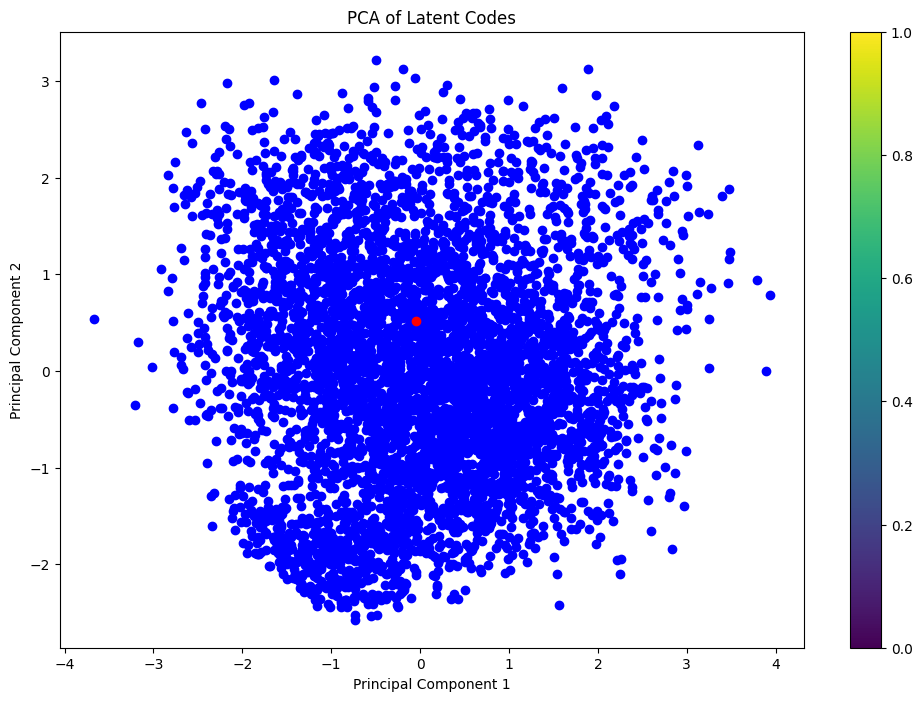

In [38]:
from sklearn.decomposition import PCA

latent_codes = np.load("./latents/latent_codes_final.npy")
labels = np.load("./latents/labels.npy")
latent_code_ood = model.encode(tensor.to(device))[0].cpu().detach().numpy()
latent_codes = np.concatenate([latent_codes, latent_code_ood])
pca = PCA(n_components=2).fit(latent_codes)
latent_codes_pca = pca.transform(latent_codes)
latent_code_ood_pca = pca.transform(latent_code_ood)


plt.figure(figsize=(12, 8))
plt.scatter(latent_codes_pca[:, 0], latent_codes_pca[:, 1], c='blue', cmap='tab10')
plt.scatter(latent_code_ood_pca[:, 0], latent_code_ood_pca[:, 1], c='red', label='OOD')
plt.colorbar()
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA of Latent Codes")
plt.show()